### Regularization
```
Regularization 中文是正则化，可以理解为一种减少方差的策略。
在机器学习中，误差可以分解为：偏差，方差与噪声之和。即误差=偏差+方差+噪声
偏差度量了学习算法的期望预测与真实结果的偏离程度，即刻画了学习算法本身的拟合能力。
方差度量了同样大小的训练集的变动所导致的学习性能的变化，即刻画了数据扰动所造成的影响。
噪声则表达了在当前任务上学习任何算法所能达到的期望泛化误差的下界。
正则化方式有 L1 和 L2 正则项两种。其中 L2 正则项又被称为权值衰减(weight decay)。
```
当没有正则项时：$\boldsymbol{O} \boldsymbol{b} \boldsymbol{j}=\boldsymbol{L} \boldsymbol{o} \boldsymbol{s} \boldsymbol{s}$，$w{i+1}=w{i}-\frac{\partial o b j}{\partial w{i}}=w{i}-\frac{\partial L o s s}{\partial w_{i}}$。
当使用 L2 正则项时，$\boldsymbol{O} \boldsymbol{b} \boldsymbol{j}=\boldsymbol{L} \boldsymbol{o} \boldsymbol{s} \boldsymbol{s}+\frac{\lambda}{2}  \sum{i}^{N} \boldsymbol{w}{i}^{2}$，$\begin{aligned} w{i+1}=w{i}-\frac{\partial o b j}{\partial w{i}} &=w{i}-\left(\frac{\partial L o s s}{\partial w_{i}}+\lambda  w{i}\right) =w{i}(1-\lambda)-\frac{\partial L o s s}{\partial w_{i}} \end{aligned}$，其中$0 < \lambda < 1$，所以具有权值衰减的作用。

下面代码对比了没有 weight decay 的优化器和 weight decay 为 0.01 的优化器的训练情况，在线性回归的数据集上进行实验，模型使用 3 层的全连接网络，并使用 TensorBoard 可视化每层权值的变化情况。

In [2]:
# -*- coding: utf-8 -*-
"""
通用函数
"""


import torch
import random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms


def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    if 'Normalize' in str(transform_train):
        norm_transform = list(filter(lambda x: isinstance(x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])

    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    if 'ToTensor' in str(transform_train):
        img_ = img_.detach().numpy() * 255

    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception("Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]) )

    return img_


def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


/Users/tianyongliu/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/tianyongliu/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


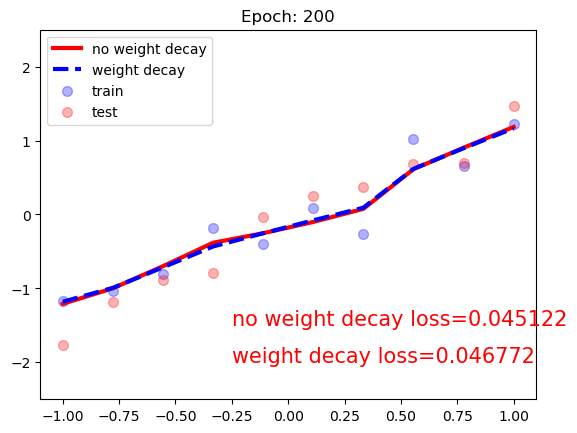

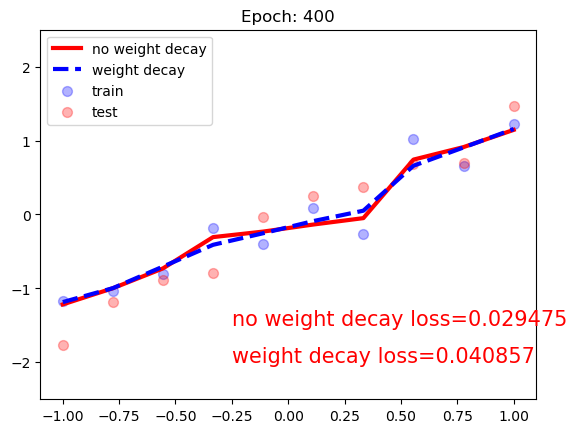

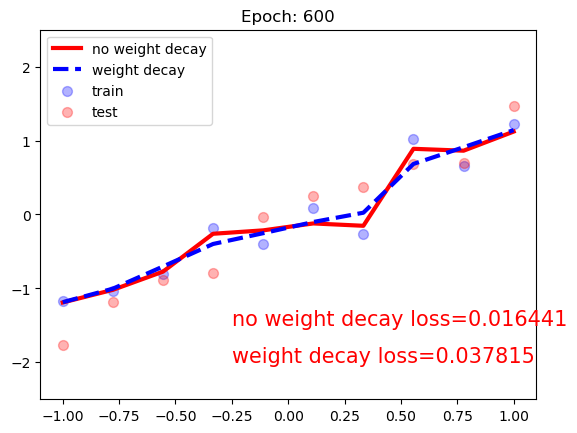

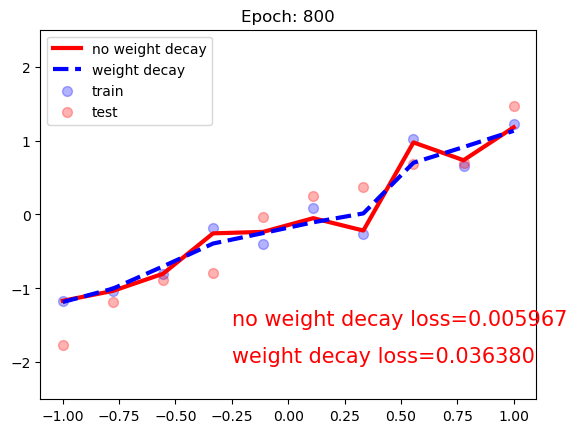

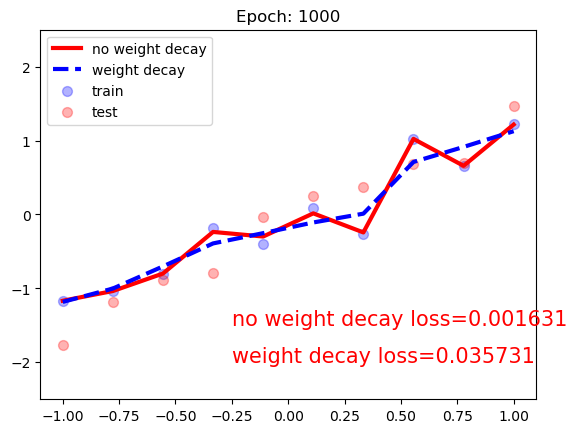

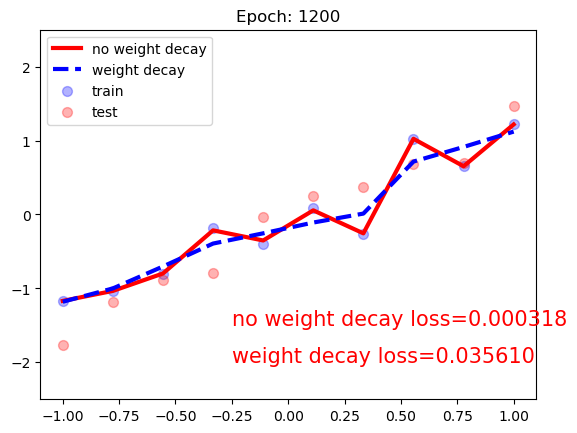

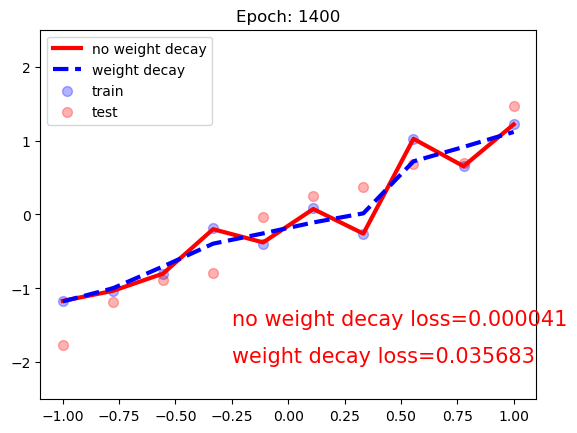

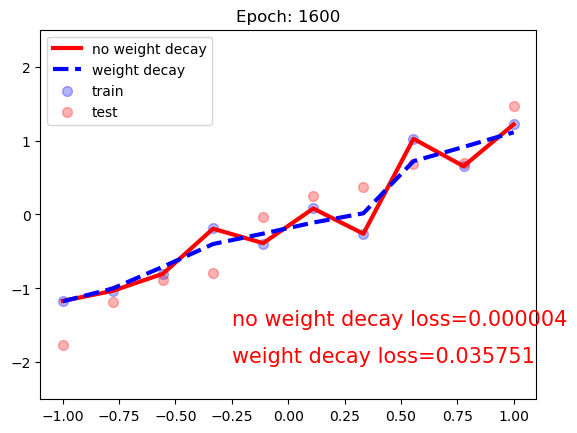

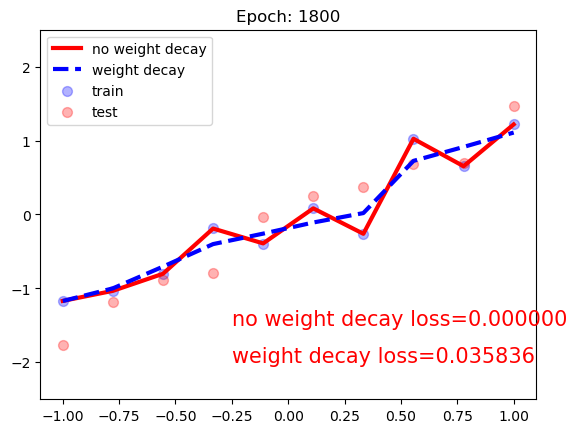

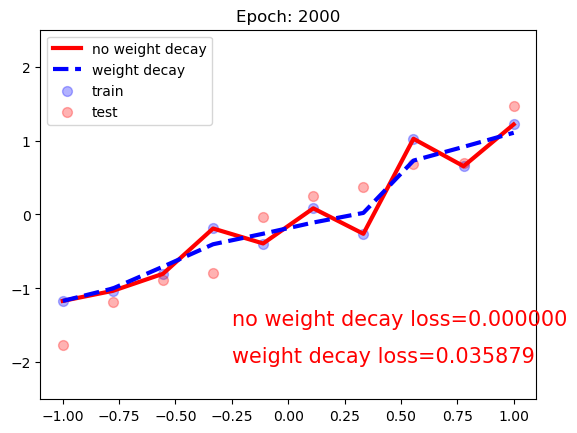

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tensorboardX import SummaryWriter

set_seed(1)  # 设置随机种子
n_hidden = 200
max_iter = 2000
disp_interval = 200
lr_init = 0.01


# ============================ step 1/5 数据 ============================
def gen_data(num_data=10, x_range=(-1, 1)):

    w = 1.5
    train_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    train_y = w*train_x + torch.normal(0, 0.5, size=train_x.size())
    test_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    test_y = w*test_x + torch.normal(0, 0.3, size=test_x.size())

    return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = gen_data(x_range=(-1, 1))


# ============================ step 2/5 模型 ============================
class MLP(nn.Module):
    def __init__(self, neural_num):
        super(MLP, self).__init__()
        self.linears = nn.Sequential(
            nn.Linear(1, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, 1),
        )

    def forward(self, x):
        return self.linears(x)


net_normal = MLP(neural_num=n_hidden)
net_weight_decay = MLP(neural_num=n_hidden)

# ============================ step 3/5 优化器 ============================
optim_normal = torch.optim.SGD(net_normal.parameters(), lr=lr_init, momentum=0.9)
optim_wdecay = torch.optim.SGD(net_weight_decay.parameters(), lr=lr_init, momentum=0.9, weight_decay=1e-2)

# ============================ step 4/5 损失函数 ============================
loss_func = torch.nn.MSELoss()

# ============================ step 5/5 迭代训练 ============================

writer = SummaryWriter(comment='_test_tensorboard', filename_suffix="12345678")
for epoch in range(max_iter):

    # forward
    pred_normal, pred_wdecay = net_normal(train_x), net_weight_decay(train_x)
    loss_normal, loss_wdecay = loss_func(pred_normal, train_y), loss_func(pred_wdecay, train_y)

    optim_normal.zero_grad()
    optim_wdecay.zero_grad()

    loss_normal.backward()
    loss_wdecay.backward()

    optim_normal.step()
    optim_wdecay.step()

    if (epoch+1) % disp_interval == 0:

        # 可视化
        for name, layer in net_normal.named_parameters():
            writer.add_histogram(name + '_grad_normal', layer.grad, epoch)
            writer.add_histogram(name + '_data_normal', layer, epoch)

        for name, layer in net_weight_decay.named_parameters():
            writer.add_histogram(name + '_grad_weight_decay', layer.grad, epoch)
            writer.add_histogram(name + '_data_weight_decay', layer, epoch)

        test_pred_normal, test_pred_wdecay = net_normal(test_x), net_weight_decay(test_x)

        # 绘图
        plt.scatter(train_x.data.numpy(), train_y.data.numpy(), c='blue', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='red', s=50, alpha=0.3, label='test')
        plt.plot(test_x.data.numpy(), test_pred_normal.data.numpy(), 'r-', lw=3, label='no weight decay')
        plt.plot(test_x.data.numpy(), test_pred_wdecay.data.numpy(), 'b--', lw=3, label='weight decay')
        plt.text(-0.25, -1.5, 'no weight decay loss={:.6f}'.format(loss_normal.item()), fontdict={'size': 15, 'color': 'red'})
        plt.text(-0.25, -2, 'weight decay loss={:.6f}'.format(loss_wdecay.item()), fontdict={'size': 15, 'color': 'red'})

        plt.ylim((-2.5, 2.5))
        plt.legend(loc='upper left')
        plt.title("Epoch: {}".format(epoch+1))
        plt.show()
        plt.close()

### weight decay 在 优化器中的实现
由于 weight decay 在优化器的一个参数，因此在执行optim_wdecay.step()时，会计算 weight decay 后的梯度，具体代码如下：

In [4]:
def step(self, closure=None):
    """Performs a single optimization step.

    Arguments:
        closure (callable, optional): A closure that reevaluates the model
            and returns the loss.
    """
    loss = None
    if closure is not None:
        loss = closure()

    for group in self.param_groups:
        weight_decay = group['weight_decay']
        momentum = group['momentum']
        dampening = group['dampening']
        nesterov = group['nesterov']

        for p in group['params']:
            if p.grad is None:
                continue
            d_p = p.grad.data
            if weight_decay != 0:
                d_p.add_(weight_decay, p.data)
                ...
                ...
                ...
            p.data.add_(-group['lr'], d_p)


可以看到：dp 是计算得到的梯度，如果 weight decay 不为 0，那么更新 $d_p=dp+weight_decay \times p.data$，对应公式：$\left(\frac{\partial L o s s}{\partial w{i}}+\lambda * w_{i}\right)$。最后一行是根据梯度更新权值。

### Dropout
Dropout 是另一种抑制过拟合的方法。在使用 dropout 时，数据尺度会发生变化，如果设置 dropout_prob =0.3，那么在训练时，数据尺度会变为原来的 70%；而在测试时，执行了 model.eval() 后，dropout 是关闭的，因此所有权重需要乘以 (1-dropout_prob)，把数据尺度也缩放到 70%。
```python
torch.nn.Dropout(p=0.5, inplace=False)
```
参数：
p：主力需要注意的是，p 是被舍弃的概率，也叫失活概率

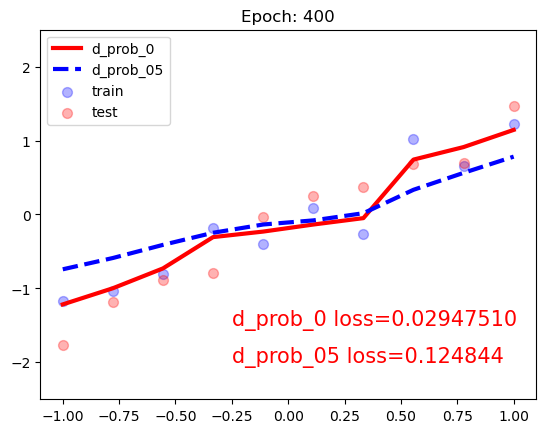

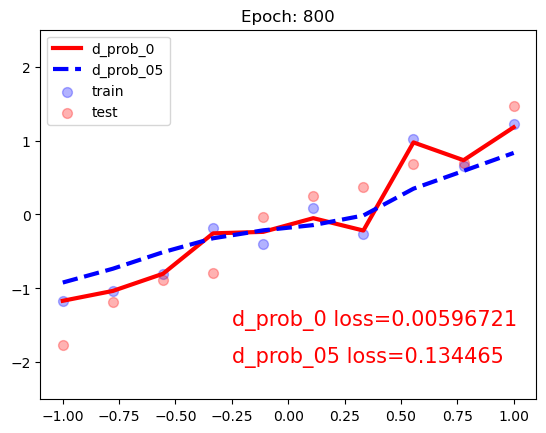

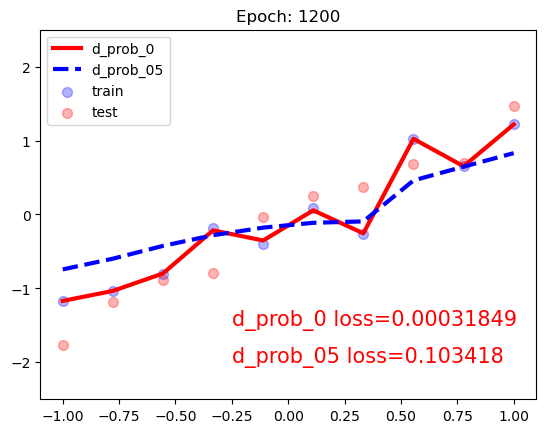

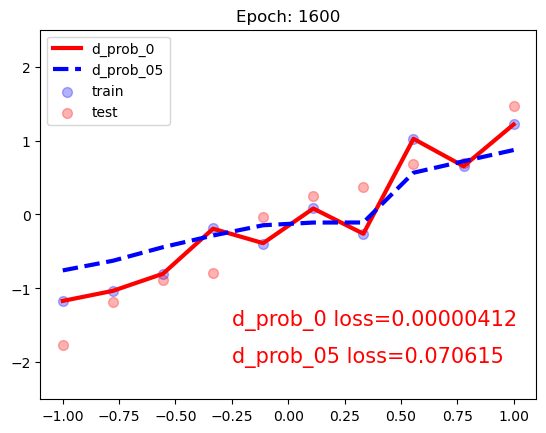

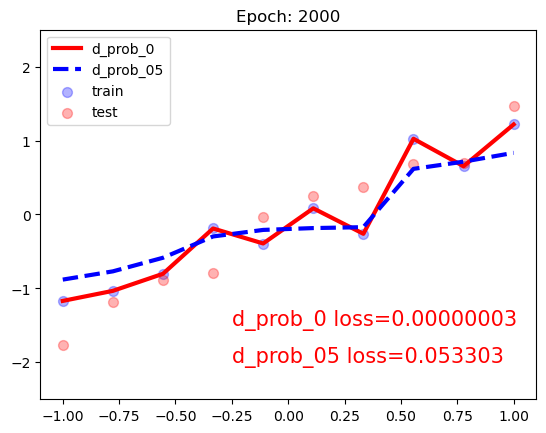

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tensorboardX import SummaryWriter

set_seed(1)  # 设置随机种子
n_hidden = 200
max_iter = 2000
disp_interval = 400
lr_init = 0.01


# ============================ step 1/5 数据 ============================
def gen_data(num_data=10, x_range=(-1, 1)):

    w = 1.5
    train_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    train_y = w*train_x + torch.normal(0, 0.5, size=train_x.size())
    test_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    test_y = w*test_x + torch.normal(0, 0.3, size=test_x.size())

    return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = gen_data(x_range=(-1, 1))


# ============================ step 2/5 模型 ============================
class MLP(nn.Module):
    def __init__(self, neural_num, d_prob=0.5):
        super(MLP, self).__init__()
        self.linears = nn.Sequential(

            nn.Linear(1, neural_num),
            nn.ReLU(inplace=True),

            nn.Dropout(d_prob),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),

            nn.Dropout(d_prob),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),

            nn.Dropout(d_prob),
            nn.Linear(neural_num, 1),
        )

    def forward(self, x):
        return self.linears(x)


net_prob_0 = MLP(neural_num=n_hidden, d_prob=0.)
net_prob_05 = MLP(neural_num=n_hidden, d_prob=0.5)

# ============================ step 3/5 优化器 ============================
optim_normal = torch.optim.SGD(net_prob_0.parameters(), lr=lr_init, momentum=0.9)
optim_reglar = torch.optim.SGD(net_prob_05.parameters(), lr=lr_init, momentum=0.9)

# ============================ step 4/5 损失函数 ============================
loss_func = torch.nn.MSELoss()

# ============================ step 5/5 迭代训练 ============================

writer = SummaryWriter(comment='_test_tensorboard', filename_suffix="12345678")
for epoch in range(max_iter):

    pred_normal, pred_wdecay = net_prob_0(train_x), net_prob_05(train_x)
    loss_normal, loss_wdecay = loss_func(pred_normal, train_y), loss_func(pred_wdecay, train_y)

    optim_normal.zero_grad()
    optim_reglar.zero_grad()

    loss_normal.backward()
    loss_wdecay.backward()

    optim_normal.step()
    optim_reglar.step()

    if (epoch+1) % disp_interval == 0:

        net_prob_0.eval()
        net_prob_05.eval()

        # 可视化
        for name, layer in net_prob_0.named_parameters():
            writer.add_histogram(name + '_grad_normal', layer.grad, epoch)
            writer.add_histogram(name + '_data_normal', layer, epoch)

        for name, layer in net_prob_05.named_parameters():
            writer.add_histogram(name + '_grad_regularization', layer.grad, epoch)
            writer.add_histogram(name + '_data_regularization', layer, epoch)

        test_pred_prob_0, test_pred_prob_05 = net_prob_0(test_x), net_prob_05(test_x)

        # 绘图
        plt.scatter(train_x.data.numpy(), train_y.data.numpy(), c='blue', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='red', s=50, alpha=0.3, label='test')
        plt.plot(test_x.data.numpy(), test_pred_prob_0.data.numpy(), 'r-', lw=3, label='d_prob_0')
        plt.plot(test_x.data.numpy(), test_pred_prob_05.data.numpy(), 'b--', lw=3, label='d_prob_05')
        plt.text(-0.25, -1.5, 'd_prob_0 loss={:.8f}'.format(loss_normal.item()), fontdict={'size': 15, 'color': 'red'})
        plt.text(-0.25, -2, 'd_prob_05 loss={:.6f}'.format(loss_wdecay.item()), fontdict={'size': 15, 'color': 'red'})

        plt.ylim((-2.5, 2.5))
        plt.legend(loc='upper left')
        plt.title("Epoch: {}".format(epoch+1))
        plt.show()
        plt.close()

        net_prob_0.train()
        net_prob_05.train()

### model.eval() 和 model.trian()
```
有些网络层在训练状态和测试状态是不一样的，如 dropout 层，在训练时 dropout 层是有效的，但是数据尺度会缩放，为了保持数据尺度不变，所有的权重需要除以 1-p。而在测试时 dropout 层是关闭的。因此在测试时需要先调用model.eval()设置各个网络层的的training属性为 False，在训练时需要先调用model.train()设置各个网络层的的training属性为 True。

In [10]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, neural_num, d_prob=0.5):
        super(Net, self).__init__()

        self.linears = nn.Sequential(
            nn.Dropout(d_prob),
            nn.Linear(neural_num, 1, bias=False),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.linears(x)

input_num = 10000
x = torch.ones((input_num, ), dtype=torch.float32)

net = Net(input_num, d_prob=0.5)
net.linears[1].weight.detach().fill_(1.)

net.train()
y = net(x)
print("output in training mode", y)

net.eval()
y = net(x)
print("output in eval mode", y)

output in training mode tensor([10072.], grad_fn=<ReluBackward0>)
output in eval mode tensor([10000.], grad_fn=<ReluBackward0>)
